In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.metrics
import sklearn.svm
from pandas.tools.plotting import scatter_matrix

%matplotlib inline

In [3]:
# Carga datos
data = pd.read_csv('spam7.csv')
data.rename(columns={'yesno':'target'}, inplace=True)
print(data.keys())
# Descarta una de las columnas que no es util
data = data.drop(['Unnamed: 0'],axis=1)

# Normaliza los datos a media cero y desviacion estandar uno
predictors = list(data.keys())
predictors.remove('target')
data[predictors] = (data[predictors] - np.mean(data[predictors]))/np.std(data[predictors])
print(predictors)

Index(['Unnamed: 0', 'crl.tot', 'dollar', 'bang', 'money', 'n000', 'make',
       'target'],
      dtype='object')
['crl.tot', 'dollar', 'bang', 'money', 'n000', 'make']


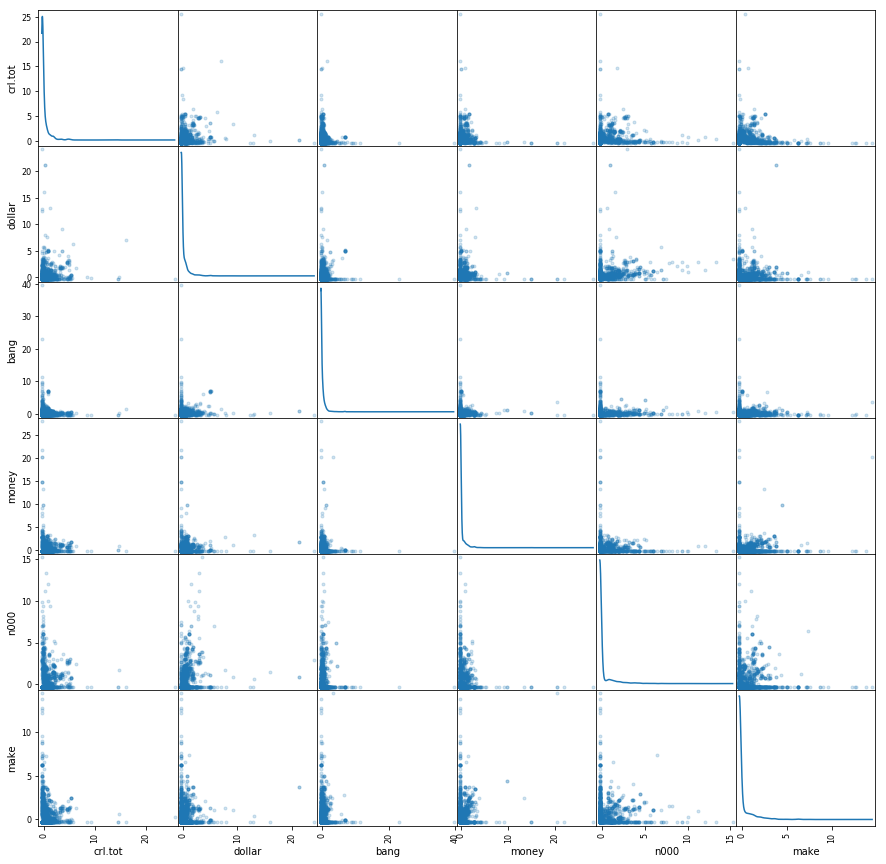

In [4]:
_ = scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='kde')

In [5]:
# Divide en train y test. Train se va a utilizar como cross validation
train_data, test_data = sklearn.model_selection.train_test_split(data, train_size=0.6)

In [7]:
def compute_F1(precision, recall):
    return 2.0 * (precision * recall) / (precision + recall)

In [8]:
def cross_validation(train_data, test_data, method, n_bootstrap=10):
    n_classes = len(list(set(train_data['target'])))
    F1_train = np.ones((n_bootstrap, n_classes))
    F1_valid = np.ones((n_bootstrap, n_classes))
    F1_test = np.ones((n_bootstrap, n_classes))
    for i in range(n_bootstrap):
        n_train = len(train_data)
        i_all = np.arange(n_train) # Todos los indices 
        i_train = np.random.choice(i_all, n_train) # Bootstraping los indices para train
        i_validation =  np.array(list(set(i_all)-set(i_train))) # Los indices no usados van para validation
        method.fit(train_data[predictors].iloc[i_train], train_data['target'].iloc[i_train])
    
        precision_train, recall_train, _, _ = sklearn.metrics.precision_recall_fscore_support(train_data['target'].iloc[i_train], 
                                                                                          method.predict(train_data[predictors].iloc[i_train]))
        precision_valid, recall_valid, _, _ = sklearn.metrics.precision_recall_fscore_support(train_data['target'].iloc[i_validation], 
                                                                                          method.predict(train_data[predictors].iloc[i_validation]))
        precision_test, recall_test, _, _ = sklearn.metrics.precision_recall_fscore_support(test_data['target'], 
                                                                                        method.predict(test_data[predictors]))

        F1_train[i,:] = compute_F1(precision_train, recall_train)
        F1_valid[i,:] = compute_F1(precision_valid, recall_valid)
        F1_test[i,:] = compute_F1(precision_test, recall_test)
  
    return {'F1_train_mean':F1_train.mean(axis=0), 
            'F1_train_std':F1_train.std(axis=0),
            'F1_valid_mean':F1_valid.mean(axis=0), 
            'F1_valid_std':F1_valid.std(axis=0),
            'F1_test_mean':F1_test.mean(axis=0), 
            'F1_test_std':F1_test.std(axis=0),
            'classes': method.classes_,
            'params': method.get_params()}

In [ ]:
n_c = 10
C_values = np.logspace(-4,4, n_c)

results_linear = {}
for i in range(n_c):
    linear = sklearn.svm.SVC(C=C_values[i], kernel='linear')
    results_linear[i] = cross_validation(train_data, test_data, linear)

In [ ]:
n_g = 10
gamma_values = np.logspace(-4,4, n_g)

results_radial = {}
for i in range(n_g):
    radial = sklearn.svm.SVC(gamma=gamma_values[i], kernel='rbf')
    results_radial[i] = cross_validation(train_data, test_data, radial)

In [21]:
results_linear[0]

{'F1_test_mean': array([0.74544777, 0.01297944]),
 'F1_test_std': array([0.00021149, 0.00218851]),
 'F1_train_mean': array([0.76017106, 0.02009938]),
 'F1_train_std': array([0.00567986, 0.00886874]),
 'F1_valid_mean': array([0.76203487, 0.01775353]),
 'F1_valid_std': array([0.00716795, 0.00735585]),
 'classes': array(['n', 'y'], dtype=object),
 'params': {'C': 0.0001,
  'cache_size': 200,
  'class_weight': None,
  'coef0': 0.0,
  'decision_function_shape': None,
  'degree': 3,
  'gamma': 'auto',
  'kernel': 'linear',
  'max_iter': -1,
  'probability': False,
  'random_state': None,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False}}

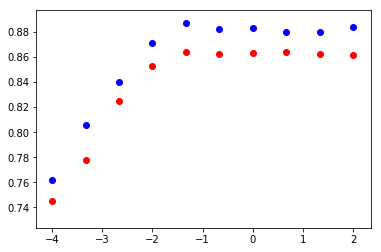

In [26]:
for k in results_linear.keys():
    plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_test_mean'][0], color='red')
    plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_valid_mean'][0], color='blue')
    #plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_test_mean'][0], color='green')

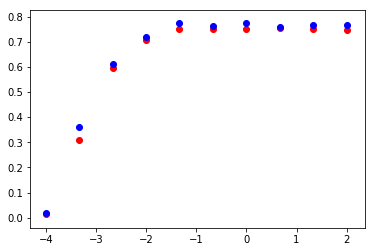

In [27]:
for k in results_linear.keys():
    plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_test_mean'][1], color='red')
    plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_valid_mean'][1], color='blue')
    #plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_test_mean'][1], color='green')

In [29]:
results_radial[0]

{'F1_test_mean': array([0.75367431, 0.1027076 ]),
 'F1_test_std': array([0.00195372, 0.01779768]),
 'F1_train_mean': array([0.77429438, 0.1379637 ]),
 'F1_train_std': array([0.00568855, 0.03377003]),
 'F1_valid_mean': array([0.77340275, 0.13931804]),
 'F1_valid_std': array([0.00914168, 0.03559449]),
 'classes': array(['n', 'y'], dtype=object),
 'params': {'C': 1.0,
  'cache_size': 200,
  'class_weight': None,
  'coef0': 0.0,
  'decision_function_shape': None,
  'degree': 3,
  'gamma': 0.0001,
  'kernel': 'rbf',
  'max_iter': -1,
  'probability': False,
  'random_state': None,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False}}

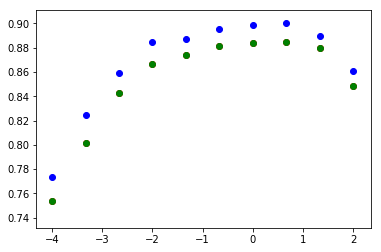

In [34]:
for k in results_radial.keys():
    plt.scatter(np.log10(results_radial[k]['params']['gamma']), results_radial[k]['F1_test_mean'][0], color='red')
    plt.scatter(np.log10(results_radial[k]['params']['gamma']), results_radial[k]['F1_valid_mean'][0], color='blue')
    plt.scatter(np.log10(results_radial[k]['params']['gamma']), results_radial[k]['F1_test_mean'][0], color='green')

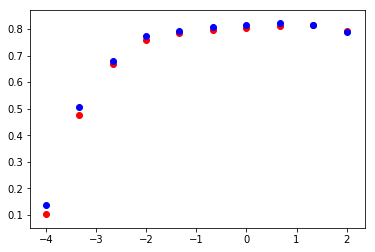

In [32]:
for k in results_radial.keys():
    plt.scatter(np.log10(results_radial[k]['params']['gamma']), results_radial[k]['F1_test_mean'][1], color='red')
    plt.scatter(np.log10(results_radial[k]['params']['gamma']), results_radial[k]['F1_valid_mean'][1], color='blue')
    #plt.scatter(np.log10(results_linear[k]['params']['C']), results_linear[k]['F1_test_mean'][1], color='green')

Text(0,0.5,'Precision')

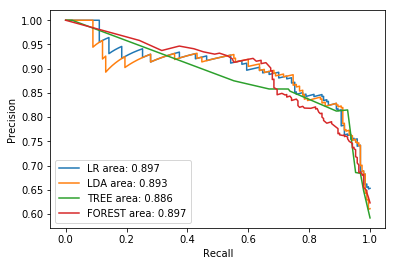

In [11]:
for k in modelos.keys():
    probas = modelos[k].predict_proba(test_data[predictors])
    precision, recall, _ = sklearn.metrics.precision_recall_curve(test_data.Target, probas[:,1])
    ii = np.argsort(recall)
    area = scipy.integrate.trapz(precision[ii], recall[ii])
    plt.plot(recall, precision, label=k+' area: {:.3f}'.format(area))
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')


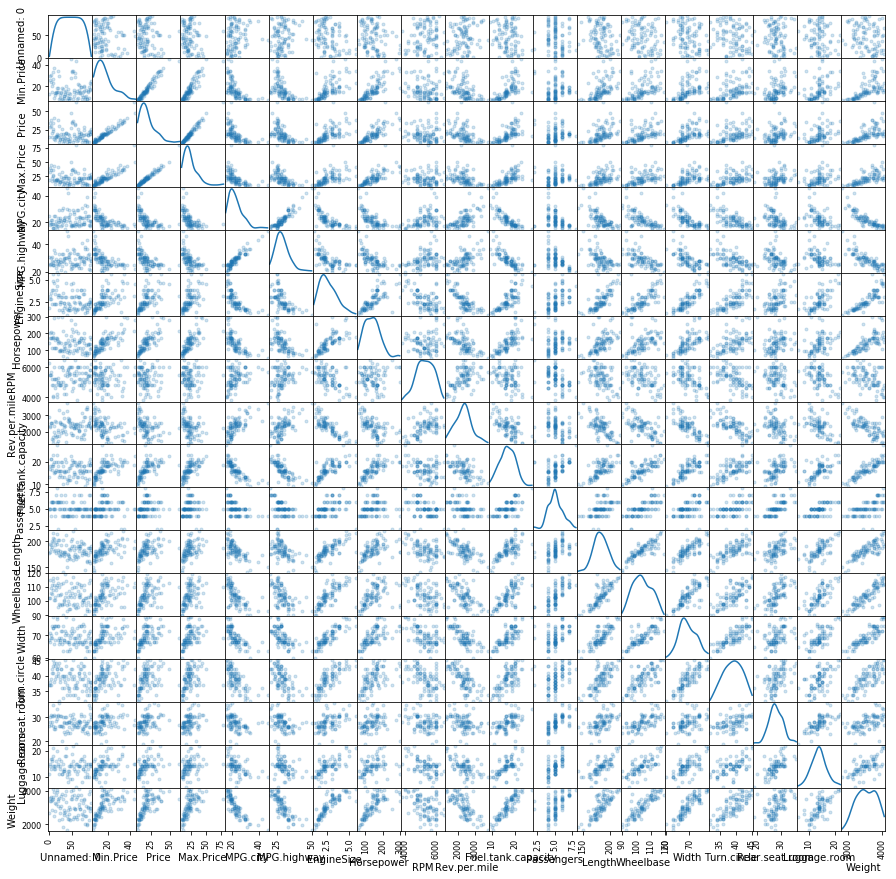

In [13]:
data = pd.read_csv('Cars93.csv')
_ = scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='kde')

In [15]:
data['MPG.city']

0     25
1     18
2     20
3     19
4     22
5     22
6     19
7     16
8     19
9     16
10    16
11    25
12    25
13    19
14    21
15    18
16    15
17    17
18    17
19    20
20    23
21    20
22    29
23    23
24    22
25    17
26    21
27    18
28    29
29    20
      ..
63    29
64    24
65    17
66    21
67    24
68    23
69    18
70    19
71    23
72    31
73    23
74    19
75    19
76    19
77    20
78    28
79    33
80    25
81    23
82    39
83    32
84    25
85    22
86    18
87    25
88    17
89    21
90    18
91    21
92    20
Name: MPG.city, dtype: int64

In [29]:
mpgbinary = np.ones(len(data), dtype=int)
mpgbinary[data['MPG.city']<np.median(data['MPG.city'])]=0

data['Target'] = mpgbinary
print(data.keys())
#print(data['Target'])

Index(['Unnamed: 0', 'Manufacturer', 'Model', 'Type', 'Min.Price', 'Price',
       'Max.Price', 'MPG.city', 'MPG.highway', 'AirBags', 'DriveTrain',
       'Cylinders', 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile',
       'Man.trans.avail', 'Fuel.tank.capacity', 'Passengers', 'Length',
       'Wheelbase', 'Width', 'Turn.circle', 'Rear.seat.room', 'Luggage.room',
       'Weight', 'Origin', 'Make', 'Target'],
      dtype='object')


In [58]:
predictors=['Fuel.tank.capacity', 'Horsepower', 'Length', 'Rev.per.mile', 'Turn.circle', 'Weight']
           # 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile',
      #  'Fuel.tank.capacity', 'Passengers', 'Length',
      # 'Wheelbase', 'Width', 'Turn.circle']
model_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4)
model_tree.fit(data[predictors], data.Target)
print(np.array(predictors)[np.argsort(model_tree.feature_importances_)])
print(model_tree.feature_importances_[np.argsort(model_tree.feature_importances_)])

['Horsepower' 'Rev.per.mile' 'Turn.circle' 'Length' 'Fuel.tank.capacity'
 'Weight']
[0.01328029 0.01844064 0.02501314 0.03893023 0.1082443  0.79609139]


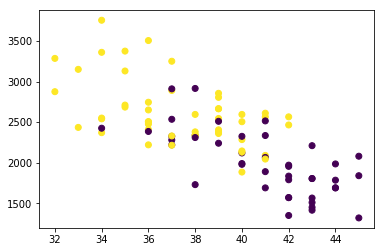

In [62]:
plt.scatter(data['Turn.circle'], data['Rev.per.mile'], c=data['Target'])

De manera sorprendente el mejor modelo parece ser **Logistic Regresion**.